## 0. Imports

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import pandas_ta as ta
import datetime
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Read data into Dataframe

In [2]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')

## 2. Prepare data

### 2.1 Add SMA (simple moving average) for 10, 20 and 60 days

In [3]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

In [4]:
sma_list = [10, 20, 60]

for sma in sma_list:
    if sma == 10:
        sma_10_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma10 = pd.DataFrame(ta.sma(test_df[ratio], length=10))
            loop_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_10': f'{ratio}_SMA_10'}, inplace=True)
            sma_10_df_prep = pd.concat([sma_10_df_prep, loop_df], axis=1, ignore_index=False)
            sma_10_df = sma_10_df_prep.iloc[:, 3:]
    
    elif sma == 20:
        sma_20_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma20 = pd.DataFrame(ta.sma(test_df[ratio], length=20))
            loop_df = pd.concat([test_df, sma20], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_20': f'{ratio}_SMA_20'}, inplace=True)
            sma_20_df_prep = pd.concat([sma_20_df_prep, loop_df], axis=1, ignore_index=False)
            sma_20_df = sma_20_df_prep.iloc[:, 3:]
    
    else:
        sma_60_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma60 = pd.DataFrame(ta.sma(test_df[ratio], length=60))
            loop_df = pd.concat([test_df, sma60], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_60': f'{ratio}_SMA_60'}, inplace=True)
            sma_60_df_prep = pd.concat([sma_60_df_prep, loop_df], axis=1, ignore_index=False)
            sma_60_df = sma_60_df_prep.iloc[:, 3:]

### 2.2 Add RSI (relative strength index) for 14 days

In [31]:
rsi_14_df_prep = pd.DataFrame(df['Date'])

for ratio in df.columns:
    test_df = df[['Date', ratio]]
    rsi14 = pd.DataFrame(ta.rsi(test_df[ratio], length=14))
    loop_df = pd.concat([test_df, rsi14], axis=1, ignore_index=False)
    loop_df.rename(columns={'RSI_14': f'{ratio}_RSI_14'}, inplace=True)
    rsi_14_df_prep = pd.concat([rsi_14_df_prep, loop_df], axis=1, ignore_index=False)
    rsi_14_df = rsi_14_df_prep.iloc[:, 3:]

### 2.3 Concatenate all 4 DFs

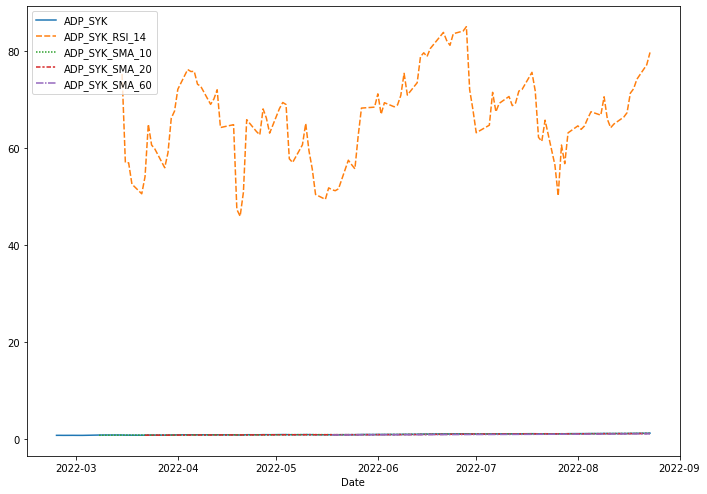

In [39]:
concat_10_20_df = pd.concat([sma_10_df, sma_20_df], axis=1)
concat_10_20_60_df = pd.concat([concat_10_20_df, sma_60_df], axis=1)
combined_df = pd.concat([concat_10_20_60_df, rsi_14_df], axis=1)
# remove duplicates of 'Date' column
dropped_date_df = combined_df.loc[:,~combined_df.columns.duplicated()]
dropped_date_df.set_index('Date', inplace=True)
# sort the ratios by column name
sorted_df = dropped_date_df.reindex(sorted(dropped_date_df.columns, reverse=False), axis=1)
# test plot for the first ratio
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.lineplot(data=sorted_df.iloc[:, :5]);

- sorted_df contains all ratios with SMA for 10, 20, 60 days and RSI for 14 days. 
- We will load each time series to the XGBoost model separately
- But first, we need to create the features and labels

# Model test

In [187]:
ratio_df = sorted_df.iloc[:, :5]

In [188]:
# add price features
# the new column contains the %age change of each day compared to the prior 5 days
ratio_df['5d_close_pct'] = ratio_df['ADP_SYK'].pct_change(5)

/var/folders/9c/wqkq2b6j16l2hg0gd5_m7sj00000gn/T/ipykernel_34565/1049723737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_df['5d_close_pct'] = ratio_df['ADP_SYK'].pct_change(5)


In [189]:
ratio_df['5d_future_close'] = ratio_df['ADP_SYK'].shift(-5)

/var/folders/9c/wqkq2b6j16l2hg0gd5_m7sj00000gn/T/ipykernel_34565/2985685657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_df['5d_future_close'] = ratio_df['ADP_SYK'].shift(-5)


In [190]:
ratio_df['5d_future_close_pct'] = ratio_df['5d_future_close'].pct_change(5)

/var/folders/9c/wqkq2b6j16l2hg0gd5_m7sj00000gn/T/ipykernel_34565/1482787446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_df['5d_future_close_pct'] = ratio_df['5d_future_close'].pct_change(5)


In [191]:
# add datetime features and concatenate with ratio_df
days_of_week = pd.get_dummies(ratio_df.index.dayofweek, prefix='weekday', drop_first=True)
ratio_df = pd.concat([ratio_df.reset_index(), days_of_week], axis=1, ignore_index=False)

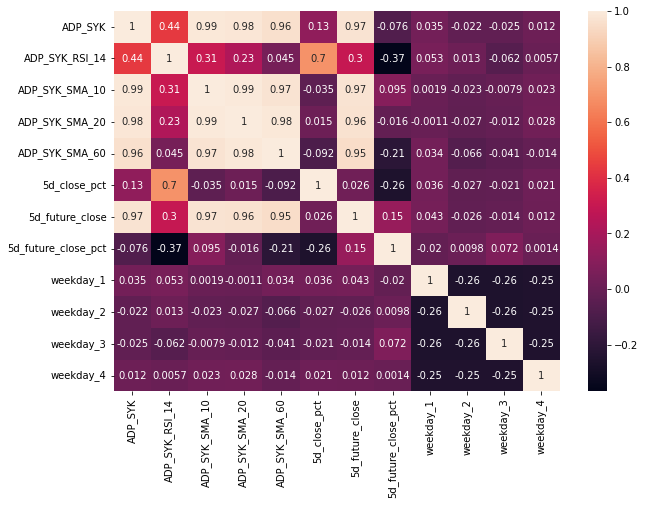

In [192]:
corr1 = ratio_df.corr()
dims = (10, 7)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(corr1, annot=True, fmt='.2g');

In [247]:
# extract features for modelling
feature_names = ['5d_close_pct', 'ADP_SYK_SMA_10', 'ADP_SYK_SMA_20', 'ADP_SYK_SMA_60', 'ADP_SYK_RSI_14', 
                 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']
features = ratio_df[feature_names]
targets = ratio_df['5d_future_close_pct']

In [197]:
feature_target_df = pd.concat([ratio_df[feature_names], ratio_df['5d_future_close_pct']], axis=1)

In [250]:
# make train and test sets
#linear_features = sm.add_constant(features)
linear_features = features.fillna(features.median())
target_median = targets.median()
targets.fillna(target_median, inplace=True)

train_size = int(0.85 * targets.shape[0])
X_train = linear_features[:train_size]
y_train = targets[:train_size]
X_test = linear_features[train_size:]
y_test = targets[train_size:]

In [254]:
# build the XGBoost model
xgb_reg = XGBRegressor(booster='gbtree',
                       objective='reg:squarederror',
                       max_depth=3,
                       n_estimators=100,
                       learning_rate=0.1,
                       n_jobs=-1,
                       random_state=2)

In [255]:
# fit the model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=2, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

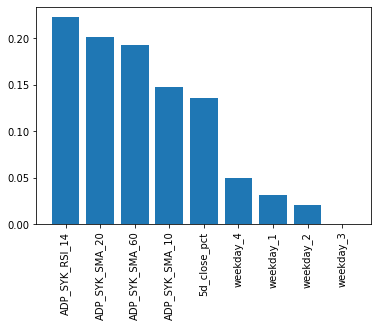

In [259]:
# check feature importances
importances = xgb_reg.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

In [278]:
# make a 5 day prediction
y_pred = pd.Series(xgb_reg.predict(X_test), name='XGBoost')
y_pred.index = ratio_df.Date[train_size:]

In [279]:
y_pred

Date
2022-07-28    0.023331
2022-07-29    0.023898
2022-08-01    0.019450
2022-08-02    0.018176
2022-08-03    0.013803
2022-08-04    0.019902
2022-08-05    0.022547
2022-08-08    0.028720
2022-08-09    0.003909
2022-08-10    0.015435
2022-08-11    0.023331
2022-08-12    0.024916
2022-08-15    0.023784
2022-08-16    0.023212
2022-08-17   -0.002251
2022-08-18   -0.006561
2022-08-19   -0.004613
2022-08-22   -0.005010
2022-08-23   -0.007034
Name: XGBoost, dtype: float32

# Model test

DO NOT CHANGE !

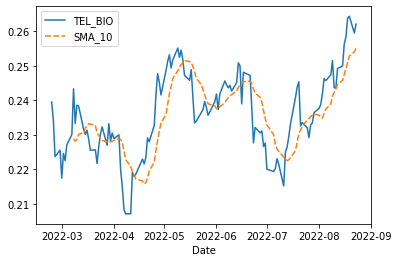

In [6]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

test_df = df[['Date', 'TEL_BIO']]
sma10 = pd.DataFrame(ta.sma(test_df["TEL_BIO"], length=10))
tel_bio_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
tel_bio_df.set_index('Date', inplace=True)
sns.lineplot(data=tel_bio_df);

DO NOT CHANGE !

In [7]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

AttributeError: Can only use .str accessor with string values!

In [ ]:
# split into 'train' and 'test' data
split_date = df['Date'][41]
df.set_index('Date', inplace=True)
train_df = df.loc[df.index <= split_date].copy()
test_df = df.loc[df.index > split_date].copy()

In [ ]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(train_df, label='number')

In [ ]:
X_test, y_test = create_features(test_df, label='number')

In [ ]:
# build first model
model = XGBRegressor(n_estimators=1000)

In [ ]:
model.fit()